In [75]:
# 1. Imports & Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pathlib import Path
import re
import warnings

warnings.filterwarnings("ignore")

# 설정 (경로는 실행 환경에 맞게 조정)
SPI_DIR = Path("../../data/processed/spi/06_spi_csv")
PRICE_PATH = Path("../../data/raw/wfp/wfp_food_prices_eastern_africa_2019-2025_10countries_118487records.csv")
WB_PATH = Path("../../ data/processed/external/worldbank_indices.csv") # 모델링 사용 시
OUTPUT_DIR = Path("../../data/analysis_results/eth_notebook_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 시각화 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [77]:
# 2. Check Data Units (Foundation)
# WFP 데이터에서 주요 작물의 단위가 섞여 있는지 확인합니다.

def check_units_preview(country):
    print("Checking Units for Key Commodities...")
    df = pd.read_csv(PRICE_PATH)
    eth = df[df['countryiso3'] == country]  # 에티오피아만 필터링
    
    targets = ['Maize', 'Sorghum', 'Wheat', 'Teff', 'Beans']
    
    for t in targets:
        subset = eth[eth['commodity'].str.contains(t, case=False)]
        print(f"\n--- {t} ---")
        # 단위별 빈도수 확인
        print(subset['unit'].value_counts())
        
check_units_preview("ETH")

Checking Units for Key Commodities...

--- Maize ---
unit
100 KG    2120
Name: count, dtype: int64

--- Sorghum ---
unit
100 KG    1474
KG          99
Name: count, dtype: int64

--- Wheat ---
unit
100 KG    2790
KG          82
Name: count, dtype: int64

--- Teff ---
Series([], Name: count, dtype: int64)

--- Beans ---
unit
100 KG    1537
Name: count, dtype: int64


In [84]:
# 3-1. Unit Normalization Logic
def extract_weight(unit_str):
    """
    '100 KG', '50 KG', 'KG' 등의 문자열에서 숫자(중량)를 추출합니다.
    숫자가 없으면 1.0으로 간주합니다.
    """
    if not isinstance(unit_str, str):
        return 1.0
    
    # 정규식으로 숫자 추출 ('90', '3.5', '100' 등)
    match = re.search(r'(\d+(\.\d+)?)', unit_str)
    if match:
        return float(match.group(1))
    return 1.0

# 3-2. Load & Preprocess Price Data
def load_and_prep_price_data(country_iso='ETH'):
    print("Loading and Preprocessing Price Data...")
    df = pd.read_csv(PRICE_PATH)
    
    # 1. 국가 필터링
    df = df[df['countryiso3'] == country_iso].copy()
    
    # 2. 날짜 변환
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    
    # 3. 주요 작물 필터링
    target_commodities = ['Maize', 'Sorghum', 'Wheat', 'Rice', 'Beans', 'Teff']
    mask = df['commodity'].apply(lambda x: any(c in x for c in target_commodities))
    df = df[mask].copy()
    
    # 4. 상품명 단순화 (ex: "Maize (white)" -> "Maize")
    def simplify_name(name):
        for c in target_commodities:
            if c in name: return c
        return name
    df['commodity_group'] = df['commodity'].apply(simplify_name)
    
    # 5. 단위 정규화 (Price per KG 계산)
    df['weight_kg'] = df['unit'].apply(extract_weight)
    df['price_per_kg'] = df['usdprice'] / df['weight_kg']
    
    # 6. 월별/작물별 평균 가격 집계
    price_agg = df.groupby(['countryiso3', 'month', 'commodity_group','commodity'])['price_per_kg'].mean().reset_index()
    return price_agg, df

price_df, df = load_and_prep_price_data()
print("Price Data Ready. Head:")
print(price_df.head())

Loading and Preprocessing Price Data...
Price Data Ready. Head:
  countryiso3      month commodity_group        commodity  price_per_kg
0         ETH 2019-01-01           Maize    Maize (white)      0.247550
1         ETH 2019-01-01         Sorghum    Sorghum (red)      0.291100
2         ETH 2019-01-01         Sorghum  Sorghum (white)      0.534700
3         ETH 2019-01-01           Wheat            Wheat      0.495250
4         ETH 2019-02-01           Maize    Maize (white)      0.258567


In [85]:
price_df[price_df['countryiso3']=='ETH'].groupby(['commodity']).count()

,countryiso3,month,commodity_group,price_per_kg
commodity,,,,
Beans,57,57,57,57
Beans (fava),66,66,66,66
Beans (haricot),66,66,66,66
"Beans (haricot, red)",1,1,1,1
"Beans (haricot, white)",1,1,1,1
Beans (kidney),8,8,8,8
Beans (mung),1,1,1,1
Maize,1,1,1,1
Maize (food aid),20,20,20,20


In [86]:
# 4. Load Pre-aggregated SPI Data
def load_spi_data():
    print("Loading Cached SPI Data...")
    
    # 이미 생성된 에티오피아 전용 집계 파일 로드
    spi_path = Path("../../data/processed/spi/06_spi_csv/eth_agg_spi_all_scales.csv")
    
    if spi_path.exists():
        spi_df = pd.read_csv(spi_path)
        spi_df['month'] = pd.to_datetime(spi_df['month'])
        
        # Merge를 위해 국가 코드 컬럼 추가
        spi_df['countryiso3'] = 'ETH'
        
        return spi_df
    else:
        print("Cached file not found! Please run the aggregation script first.")
        return pd.DataFrame()

# 4-b. Load External Data (World Bank Indices)
EXT_PATH = Path("../../data/processed/external/external_variables_merged.csv")

def load_external_data():
    print("Loading External Data...")
    if not EXT_PATH.exists():
        print(f"File not found: {EXT_PATH}")
        return pd.DataFrame()
        
    ext_df = pd.read_csv(EXT_PATH)
    ext_df['date'] = pd.to_datetime(ext_df['date'])
    ext_df['month'] = ext_df['date'].dt.to_period('M').dt.to_timestamp()
    
    print(ext_df.head())
    
    # 필요한 컬럼만 선택 (energy_index, food_index 등)
    # date 컬럼은 month가 있으므로 제외
    cols_to_use = ['month', 'energy_index', 'food_index', 'fertilizer_index']
    return ext_df[cols_to_use]

spi_df = load_spi_data()
merged_df = pd.merge(price_df, spi_df, on=['countryiso3', 'month'], how='inner')
print(f"Merged Data Shape: {merged_df.shape}")

# # 기존 merged_df에 병합
ext_df = load_external_data()
if not ext_df.empty:
    merged_df = pd.merge(merged_df, ext_df, on='month', how='left')
    print(f"Merged with External Data. New Shape: {merged_df.shape}")
else:
    print("External data load failed.")



Loading Cached SPI Data...
Merged Data Shape: (765, 10)
Loading External Data...
        date  energy_index  food_index  fertilizer_index      month
0 1960-01-01      2.134449   21.194101         28.998058 1960-01-01
1 1960-02-01      2.134449   20.885410         29.046665 1960-02-01
2 1960-03-01      2.134449   21.057413         29.425066 1960-03-01
3 1960-04-01      2.134449   21.232864         29.477998 1960-04-01
4 1960-05-01      2.134449   21.087342         30.329697 1960-05-01
Merged with External Data. New Shape: (765, 13)


Calculating Correlations...


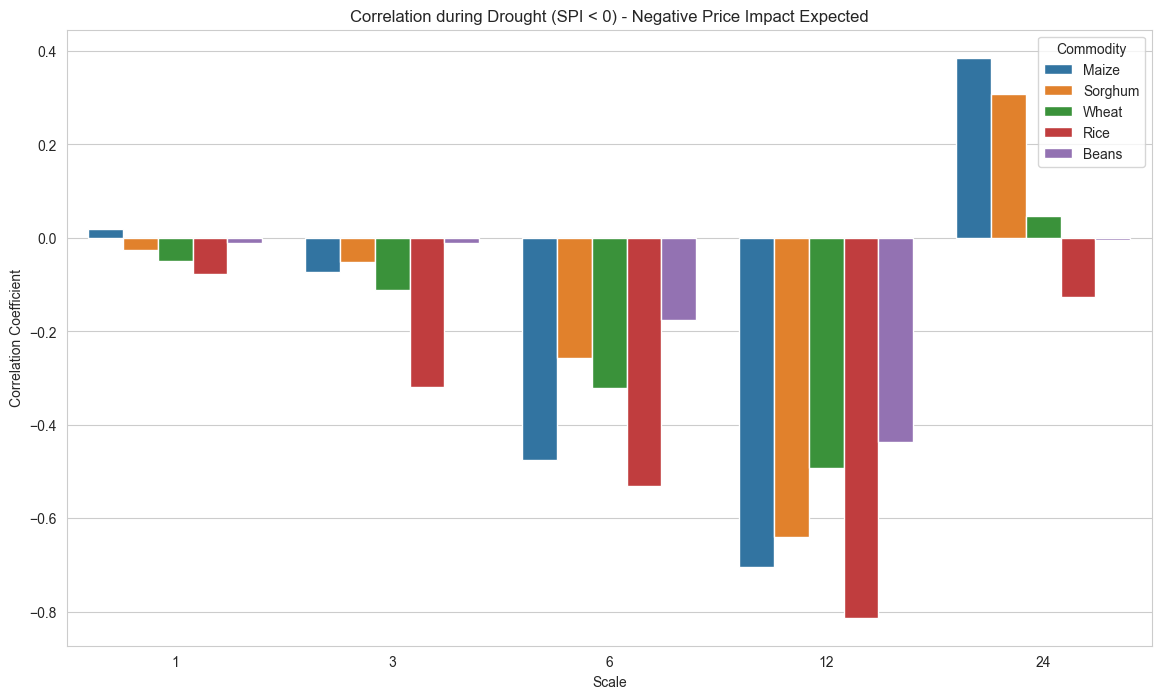

Analysis Complete. Top rows:
  Commodity  Scale  Corr_Overall  Corr_Drought  Corr_Flood
0     Maize      1      0.050033      0.018334   -0.192828
1     Maize      3      0.076521     -0.072178   -0.128483
2     Maize      6      0.101656     -0.475493    0.074631
3     Maize     12     -0.065658     -0.704505   -0.001644
4     Maize     24     -0.337412      0.385765   -0.206144


In [87]:
# 5. Split Correlation Analysis (Drought vs Flood)

results = []
print("Calculating Correlations...")

for commodity in merged_df['commodity_group'].unique():
    comm_df = merged_df[merged_df['commodity_group'] == commodity]
    merged_df['drought'] = np.where(merged_df['spi_12'] < 0, 1, 0)
    merged_df['flood'] = np.where(merged_df['spi_12'] > 0, 1, 0)
    # 각 SPI 척도별(1, 3, ... 24) 분석
    spi_cols = [c for c in merged_df.columns if c.startswith('spi_')]
    
    for scale_col in spi_cols:
        scale = int(scale_col.split('_')[1])
        valid = comm_df.dropna(subset=['price_per_kg', scale_col])
        if len(valid) < 20: continue
        
        # Split Data
        drought = valid[valid[scale_col] < 0]
        flood = valid[valid[scale_col] > 0]
        
        # Correlation
        corr_all = valid['price_per_kg'].corr(valid[scale_col])
        corr_drought = drought['price_per_kg'].corr(drought[scale_col])
        corr_flood = flood['price_per_kg'].corr(flood[scale_col])
        

        results.append({
            'Commodity': commodity,
            'Scale': scale,
            'Corr_Overall': corr_all,
            'Corr_Drought': corr_drought,
            'Corr_Flood': corr_flood
        })

res_df = pd.DataFrame(results)

# 시각화 (Commodity별 상관관계 비교)
plt.figure(figsize=(14, 8))
# Maize만 예시로 필터링하거나 전체 출력
sns.barplot(data=res_df, x='Scale', y='Corr_Drought', hue='Commodity')
plt.title("Correlation during Drought (SPI < 0) - Negative Price Impact Expected")
plt.ylabel("Correlation Coefficient")
plt.show()

print("Analysis Complete. Top rows:")
print(res_df.head())

In [88]:
merged_df

,countryiso3,month,commodity_group,commodity,price_per_kg,spi_1,spi_3,spi_6,spi_12,spi_24,energy_index,food_index,fertilizer_index,drought,flood
0,ETH,2019-01-01,Maize,Maize (white),0.247550,-0.710918,0.061747,-0.213653,0.472777,0.415200,76.204771,86.965693,70.125815,0,1
1,ETH,2019-01-01,Sorghum,Sorghum (red),0.291100,-0.710918,0.061747,-0.213653,0.472777,0.415200,76.204771,86.965693,70.125815,0,1
2,ETH,2019-01-01,Sorghum,Sorghum (white),0.534700,-0.710918,0.061747,-0.213653,0.472777,0.415200,76.204771,86.965693,70.125815,0,1
3,ETH,2019-01-01,Wheat,Wheat,0.495250,-0.710918,0.061747,-0.213653,0.472777,0.415200,76.204771,86.965693,70.125815,0,1
4,ETH,2019-02-01,Maize,Maize (white),0.258567,-0.052727,-0.450448,-0.183106,0.379411,0.345431,80.086039,87.445649,70.272975,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,ETH,2024-11-01,Rice,Rice,0.856154,0.516136,0.433862,0.705683,0.845465,1.542915,96.513796,116.163218,88.010270,0,1
761,ETH,2024-11-01,Sorghum,Sorghum (red),0.529520,0.516136,0.433862,0.705683,0.845465,1.542915,96.513796,116.163218,88.010270,0,1
762,ETH,2024-11-01,Sorghum,Sorghum (white),0.450912,0.516136,0.433862,0.705683,0.845465,1.542915,96.513796,116.163218,88.010270,0,1
763,ETH,2024-11-01,Wheat,Wheat (white),0.540483,0.516136,0.433862,0.705683,0.845465,1.542915,96.513796,116.163218,88.010270,0,1


Generating Scatter Plots for SPI-12 (Drought vs Flood)...


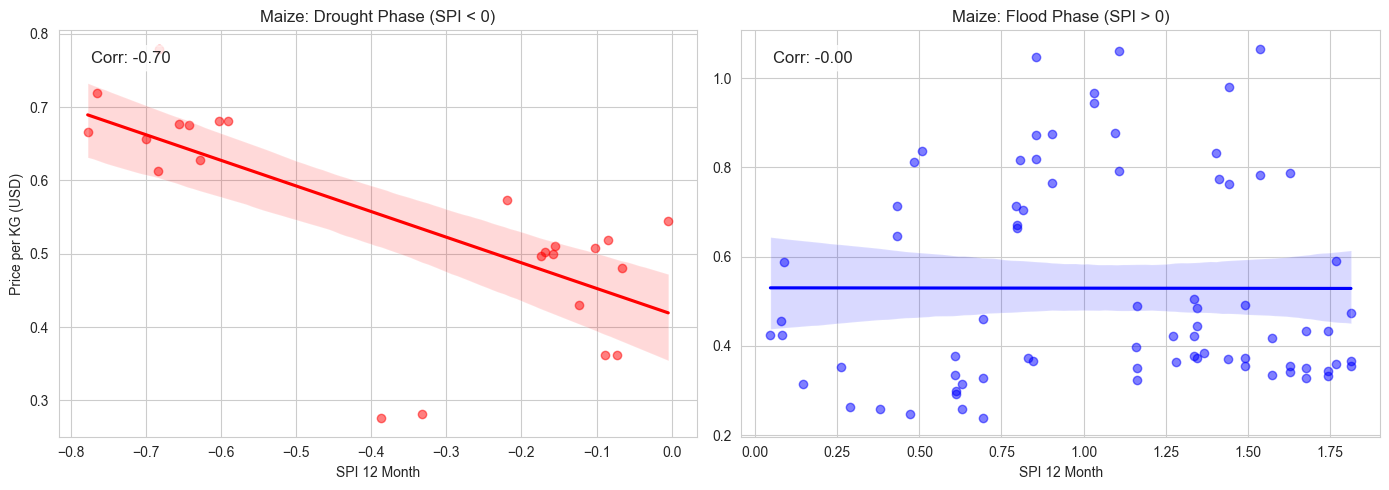

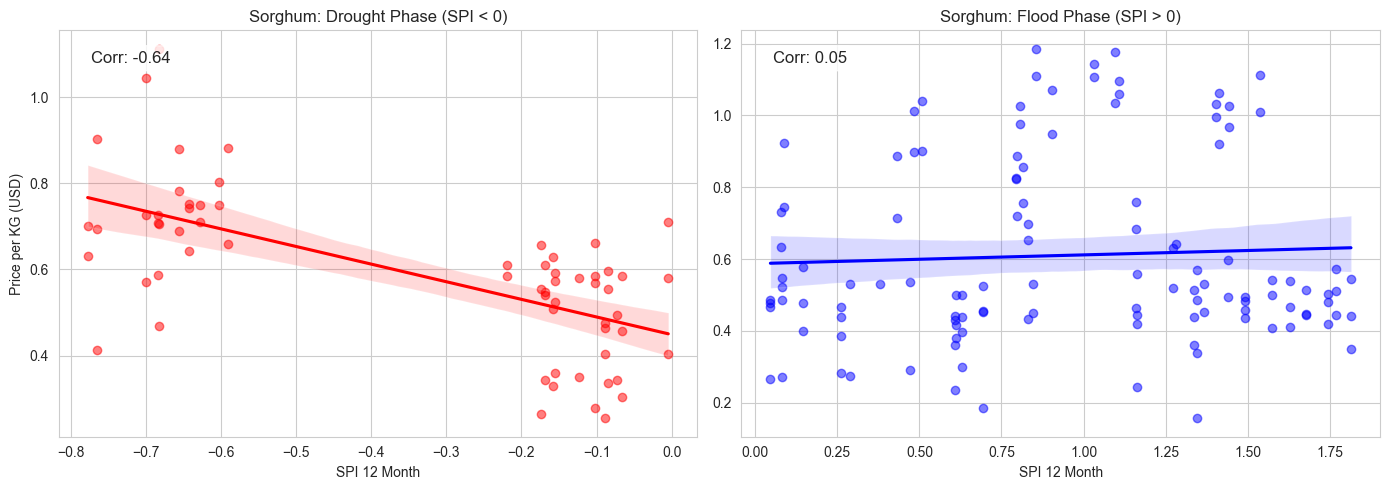

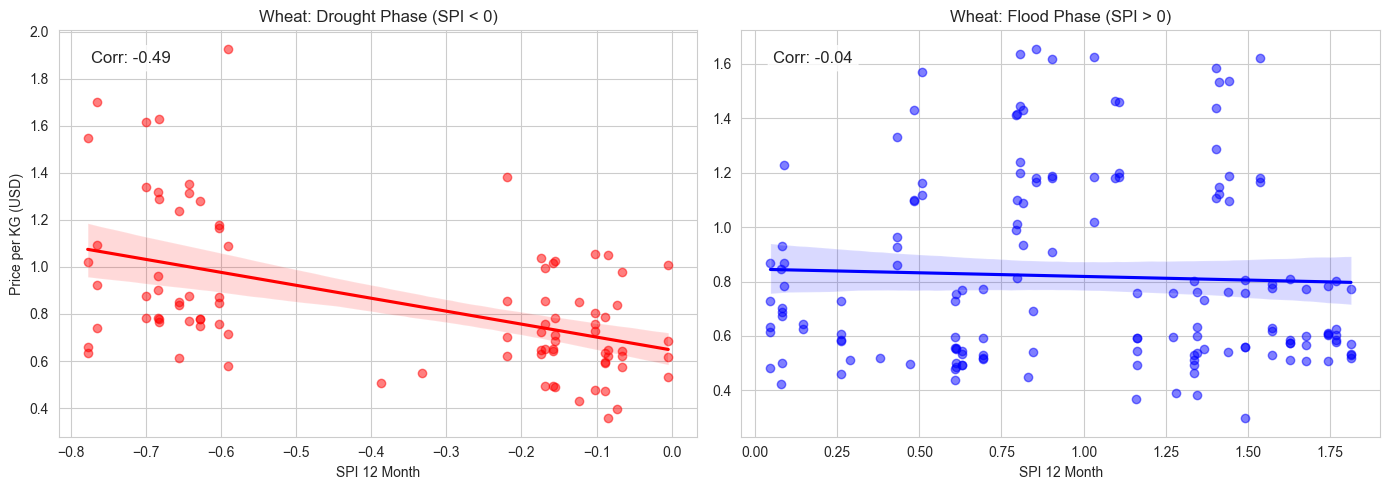

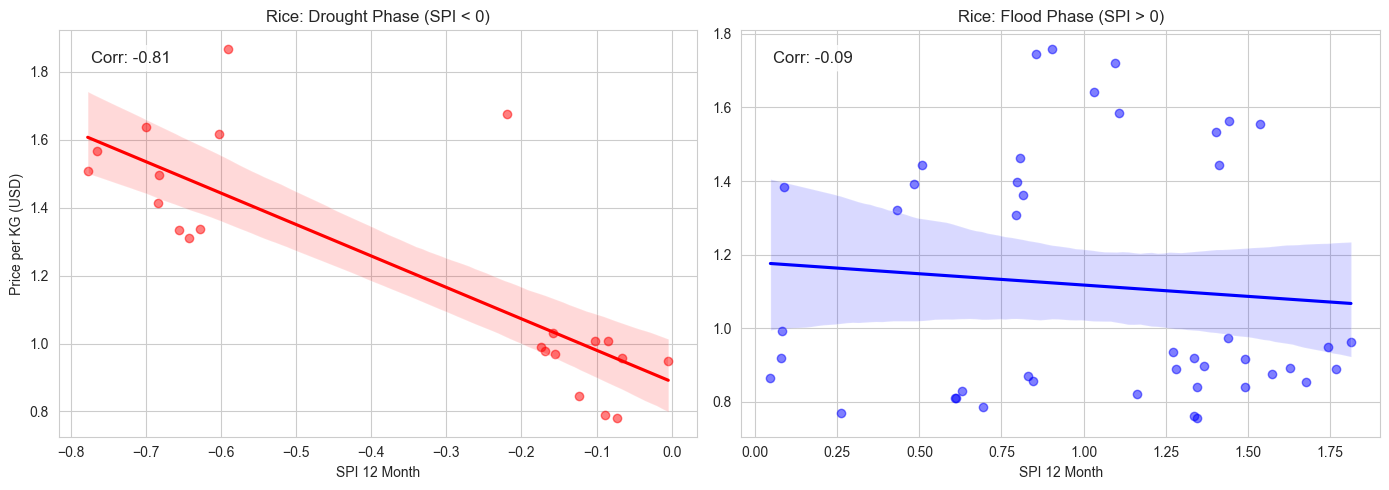

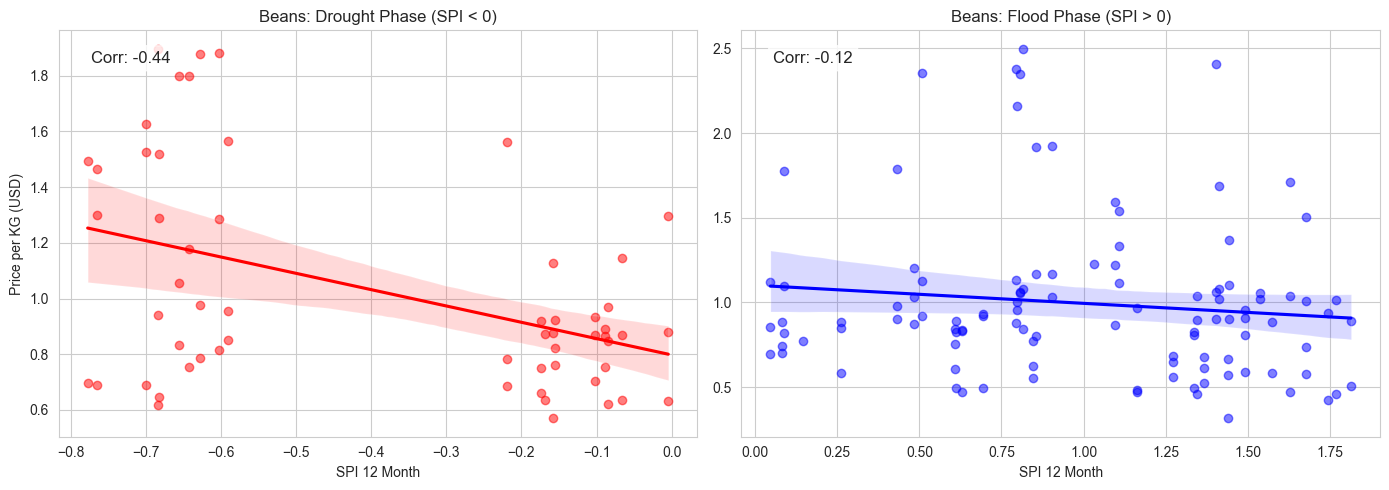

In [89]:
# 5-2. Visualize Scatter Plots (Price vs Drought/Flood)
# 1. 24개월 척도를 기준으로 산점도를 그림 (가장 대표적인 장기 척도)
target_scale = 12
spi_col = f'spi_{target_scale}'
# 주요 작물 리스트
commodities = merged_df['commodity_group'].unique()
print(f"Generating Scatter Plots for SPI-{target_scale} (Drought vs Flood)...")
# 작물별 루프
for comm in commodities:
    subset = merged_df[merged_df['commodity_group'] == comm].dropna(subset=['price_per_kg', spi_col])
    
    if len(subset) < 20: continue
    # 캔버스 설정 (1행 2열: 왼쪽은 Drought, 오른쪽은 Flood)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- [Left] Drought (SPI < 0) ---
    drought_data = subset[subset[spi_col] < 0]
    sns.regplot(data=drought_data, x=spi_col, y='price_per_kg', ax=axes[0], color='red', scatter_kws={'alpha':0.5})
    axes[0].set_title(f'{comm}: Drought Phase (SPI < 0)')
    axes[0].set_xlabel(f'SPI {target_scale} Month')
    axes[0].set_ylabel('Price per KG (USD)')
    
    # 상관계수 표시
    if len(drought_data) > 10:
        corr = drought_data['price_per_kg'].corr(drought_data[spi_col])
        axes[0].text(0.05, 0.95, f'Corr: {corr:.2f}', transform=axes[0].transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # --- [Right] Flood (SPI > 0) ---
    flood_data = subset[subset[spi_col] > 0]
    sns.regplot(data=flood_data, x=spi_col, y='price_per_kg', ax=axes[1], color='blue', scatter_kws={'alpha':0.5})
    axes[1].set_title(f'{comm}: Flood Phase (SPI > 0)')
    axes[1].set_xlabel(f'SPI {target_scale} Month')
    axes[1].set_ylabel('') # Y축 라벨 중복 제거
    # 상관계수 표시
    if len(flood_data) > 10:
        corr = flood_data['price_per_kg'].corr(flood_data[spi_col])
        axes[1].text(0.05, 0.95, f'Corr: {corr:.2f}', transform=axes[1].transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()

In [90]:
# 6. Stationarity Check (ADF Test) for Modeling
def check_stationarity(series, name="Series"):
    result = adfuller(series.dropna())
    print(f"[{name}] ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print(" => Stationary (안정적)")
    else:
        print(" => Non-Stationary (불안정, 차분 필요)")


price = merged_df[merged_df['commodity_group'] == 'Sorghum'].set_index('month')['price_per_kg']
diff_price = price.diff().dropna()
check_stationarity(diff_price, "Sorghum Price (Raw)")
check_stationarity(np.log(price).diff().dropna(), "Sorghum Price (Log)")

[Sorghum Price (Raw)] ADF Statistic: -8.3286, p-value: 0.0000
 => Stationary (안정적)
[Sorghum Price (Log)] ADF Statistic: -16.3926, p-value: 0.0000
 => Stationary (안정적)


array(['ETH'], dtype=object)

Running SARIMAX for Sorghum (red) (with External/Lagged Vars)...
Training Samples: 40, Test Samples: 18


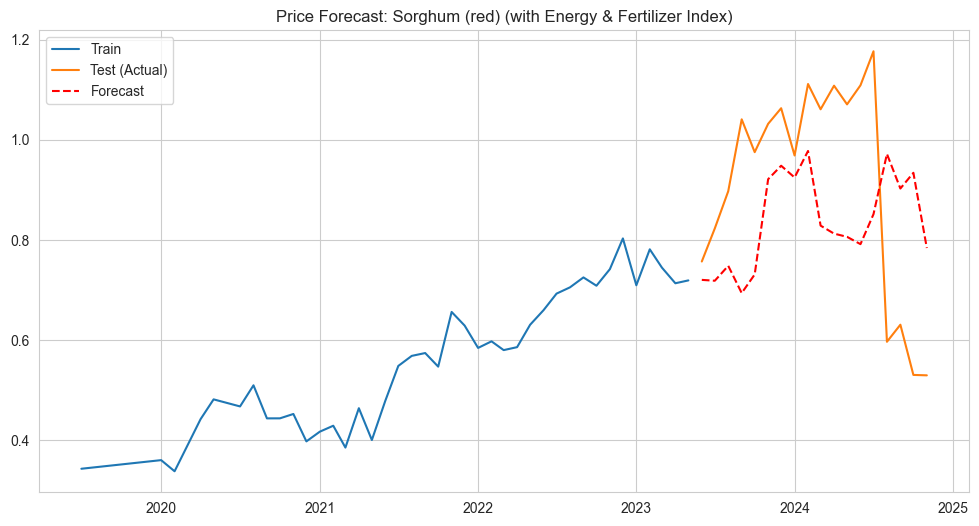

                                      SARIMAX Results                                      
Dep. Variable:                           log_price   No. Observations:                   40
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                  34.664
Date:                             Tue, 30 Dec 2025   AIC                            -35.328
Time:                                     15:53:40   BIC                            -13.940
Sample:                                          0   HQIC                           -29.169
                                              - 40                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
log_energy          -0.1595      2.028     -0.079      0.937      -4.134       3.815
energy_in

In [91]:
# 7. SARIMAX Modeling with External Variables
target_comm = 'Sorghum (red)'
target_var = 'log_price'
print(f"Running SARIMAX for {target_comm} (with External/Lagged Vars)...")

# 필터링
model_df = merged_df[merged_df['commodity'] == target_comm].copy()
model_df = model_df.sort_values('month').set_index('month').asfreq('MS')

# --- Feature Engineering ---
# 1. Target Log Transform
model_df['price_per_kg'] = model_df['price_per_kg'].interpolate()
model_df['log_price'] = np.log(model_df['price_per_kg'])

# 2. SPI Var (Best Scale: 24) & Lag
best_scale_col = 'spi_12'
# Tip: SPI 효과는 즉각적이지 않을 수 있으므로 Lag 추가
model_df['spi_lag_6'] = model_df[best_scale_col].shift(6)

model_df['drought_severe'] = np.where(model_df['spi_12'] < 0.5, 1, 0)
model_df['flood_severe'] = np.where(model_df['spi_12'] > 0.5, 1, 0)
model_df['drought_spi'] = np.where(model_df['spi_12'] < 0, model_df['spi_12'], 0)
model_df['flood_spi'] = np.where(model_df['spi_12'] > 0, model_df['spi_12'], 0)

# 3. External Vars (Log Transform recommended for indices)
# 에너지, 비료 가격지수 등을 로그 변환하여 투입
model_df['log_energy'] = np.log(model_df['energy_index'])
model_df['log_fertilizer'] = np.log(model_df['fertilizer_index'])
model_df['log_food_index'] = np.log(model_df['food_index'])
model_df['log_drought_spi'] = np.log(model_df['drought_spi']+1)
model_df['log_flood_spi'] = np.log(model_df['flood_spi']+1)

# --- Select Features ---
# 사용할 외생변수 목록
exog_vars = ['log_energy', 'energy_index', 'fertilizer_index', 'food_index','log_fertilizer','log_food_index', 'drought_severe', 'flood_severe',  'drought_spi', 'flood_spi', 'log_drought_spi', 'log_flood_spi', 'spi_lag_6',]

# 결측치 제거 (Lag로 인해 앞부분 NaN 발생 + External data 매칭 안된 부분 제거)
train_cols = [target_var] + exog_vars
data_clean = model_df[train_cols].dropna()

if data_clean.empty:
    print("Error: No data available after merging. Check date ranges.")
else:
    # Train/Test Split
    test_size = 18
    train = data_clean.iloc[:-test_size]
    test = data_clean.iloc[-test_size:]

    print(f"Training Samples: {len(train)}, Test Samples: {len(test)}")

    # SARIMAX
    try:
        model = SARIMAX(train[target_var], 
                        exog=train[exog_vars],
                        order=(1, 1, 1), 
                        seasonal_order=(1, 0, 0, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        fit = model.fit(disp=False)
        
        # Forecast
        forecast = fit.get_forecast(steps=test_size, exog=test[exog_vars])
        pred_log = forecast.predicted_mean
        pred_price = np.exp(pred_log)
        actual_price = np.exp(test[target_var])
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, np.exp(train[target_var]), label='Train')
        plt.plot(test.index, actual_price, label='Test (Actual)')
        plt.plot(test.index, pred_price, label='Forecast', linestyle='--', color='red')
        plt.title(f"Price Forecast: {target_comm} (with Energy & Fertilizer Index)")
        plt.legend()
        plt.show()
        
        # Print Summary
        print(fit.summary())
        
        rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
        print(f"RMSE: {rmse:.4f}")
        r_sq = np.corrcoef(actual_price, pred_price)[0, 1]
        print(f"R^2: {r_sq:.4f}")

    except Exception as e:
        print(f"Modeling Failed: {e}")

In [92]:
# 7-2. Best Variable Combination Search (Optimization)
from itertools import combinations
import tqdm # Progress bar

# 후보 변수 풀 (너무 많으면 조합이 폭발하므로 핵심 변수만 선정 추천)

standard_spi='spi_3'
model_df['spi_lag_6'] = model_df[standard_spi].shift(6)
model_df['drought_severe'] = np.where(model_df[standard_spi] < 0.5, 1, 0)
model_df['flood_severe'] = np.where(model_df[standard_spi] > 0.5, 1, 0)
model_df['drought_spi'] = np.where(model_df[standard_spi] < 0, model_df['spi_12'], 0)
model_df['flood_spi'] = np.where(model_df[standard_spi] > 0, model_df['spi_12'], 0)

candidates = [
    'log_energy', 'log_fertilizer', 'log_food',
    'drought_severe', 'drought_spi', 'flood_severe', 'spi_lag_6'
]
# 실제 존재하는 것만 필터링
valid_candidates = [c for c in candidates if c in model_df.columns]
print(f"Candidates: {valid_candidates}")
results = []
# 데이터 준비 (공통)
# RMSE 비교를 위해 Test 기간 고정 (Last 12 months)
train_idx = model_df.iloc[:-12].index
test_idx = model_df.iloc[-12:].index
y_train = model_df.loc[train_idx, 'log_price']
y_test = model_df.loc[test_idx, 'log_price']
# 조합 탐색 (1개 ~ 최대 3개 변수 조합 권장)
max_vars = len(valid_candidates)
comb_list = []
for k in range(1, max_vars + 1):
    comb_list.extend(list(combinations(valid_candidates, k)))
print(f"Testing {len(comb_list)} combinations...")
# 조합 탐색 (1개 ~ 최대 3개 변수, R2 추가 버전)
for feature_set in comb_list:
    features = list(feature_set)
    
    # 데이터셋 구성 & 결측치 처리
    temp_df = model_df[features + ['log_price']].dropna()
    
    # 데이터가 너무 줄어들면 패스
    if len(temp_df) < 50: continue
    
    # Train/Test matching indices
    current_train = temp_df.loc[temp_df.index.intersection(train_idx)]
    current_test = temp_df.loc[temp_df.index.intersection(test_idx)]
    
    # 테스트셋 검증
    if len(current_test) < 6: continue 
    try:
        model = SARIMAX(current_train['log_price'], 
                        exog=current_train[features],
                        order=(1,0,0), seasonal_order=(0,0,0,12),
                        enforce_stationarity=False, enforce_invertibility=False)
        fit = model.fit(disp=False)
        
        # Forecast
        forecast = fit.get_forecast(steps=len(current_test), exog=current_test[features])
        pred = np.exp(forecast.predicted_mean)
        actual = np.exp(current_test['log_price'])
        
        rmse = np.sqrt(mean_squared_error(actual, pred))
        
        # [NEW] R2 Score Calculation
        from sklearn.metrics import r2_score
        r2 = r2_score(actual, pred)
        
        results.append({
            'Features': ", ".join(features),
            'Num_Vars': len(features),
            'RMSE': rmse,
            'R2': r2,
            'AIC': fit.aic
        })
        
    except Exception as e:
        # 에러 발생 시 건너뜀
        continue
# 결과 출력
print("\n--- Top 10 Combinations by R2 Score ---")
# R2는 높을수록 좋으므로 ascending=False
res_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print(res_df.head(10))

Candidates: ['log_energy', 'log_fertilizer', 'drought_severe', 'drought_spi', 'flood_severe', 'spi_lag_6']
Testing 63 combinations...

--- Top 10 Combinations by R2 Score ---
                                             Features  Num_Vars      RMSE  \
12                        log_fertilizer, drought_spi         2  0.219000   
29                 log_energy, drought_spi, spi_lag_6         3  0.219559   
10                              log_energy, spi_lag_6         2  0.219571   
1                                      log_fertilizer         1  0.219684   
27              log_energy, drought_severe, spi_lag_6         3  0.222575   
0                                          log_energy         1  0.222667   
8                             log_energy, drought_spi         2  0.222954   
48  log_energy, drought_severe, drought_spi, spi_l...         4  0.223127   
30                log_energy, flood_severe, spi_lag_6         3  0.223911   
50   log_energy, drought_spi, flood_severe, spi_lag_6  

In [48]:
res_df['Features'].iloc[0]

'log_energy, log_fertilizer, drought_spi, flood_severe'

Original Data Length: 71
Cleaned Data Length: 65 (Drops due to NaNs/Lags)
Testing 64 parameter combinations...

------------------------------------------------
Best SARIMAX Parameters Found: (1, 0, 0) x (0, 0, 0, 12)
Best AIC: -80.26
------------------------------------------------
Final RMSE on Test Set: 0.2388


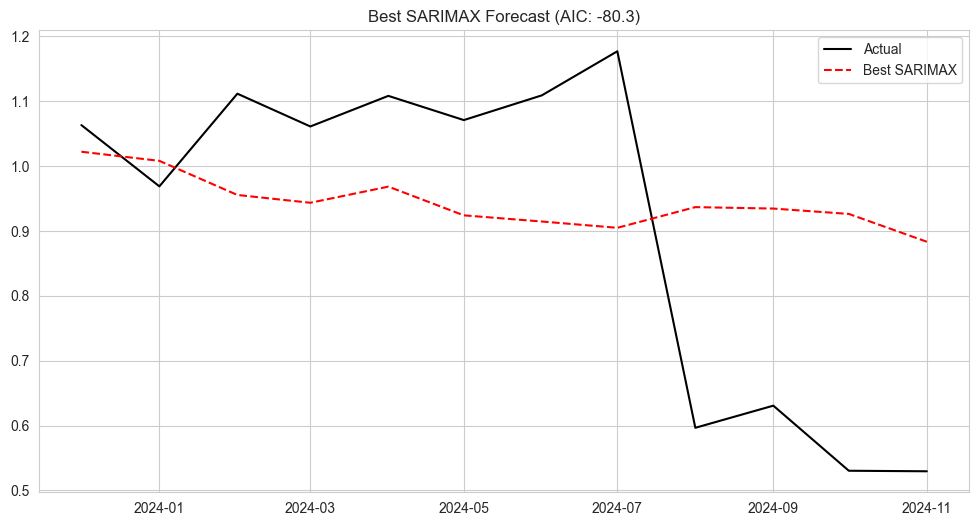

In [ ]:
# -------------------------------------------------------------
# [수정됨] 10. SARIMAX Hyperparameter Tuning (Grid Search)
# -------------------------------------------------------------
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
# 1. Data Cleaning (중요: 결측치가 있으면 무조건 에러가 납니다)
# 사용할 변수들과 타겟만 남기고 결측치 제거
data_cols = ['log_price'] + best_features
clean_data = model_df[data_cols].dropna()
print(f"Original Data Length: {len(model_df)}")
print(f"Cleaned Data Length: {len(clean_data)} (Drops due to NaNs/Lags)")
if len(clean_data) < 24:
    print("Error: Not enough data points after dropping NaNs!")
else:
    # 2. Train/Test Split (Clean Data 기준)
    train_data = clean_data.iloc[:-12]
    test_data = clean_data.iloc[-12:]
    y_train = train_data['log_price']
    X_train = train_data[best_features]
    
    # 3. Grid Search Setup
    p = d = q = range(0, 2)
    P = D = Q = range(0, 2)
    s = 12 
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]
    print(f"Testing {len(pdq) * len(seasonal_pdq)} parameter combinations...")
    best_aic = float("inf")
    best_param = None
    best_seasonal = None
    best_model = None
    
    # 4. Loop
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(y_train,
                              exog=X_train,
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                
                results = mod.fit(disp=False)
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_param = param
                    best_seasonal = param_seasonal
                    best_model = results
            
            except Exception as e:
                # 에러가 계속 나면 아래 주석을 풀어 원인을 확인하세요
                # print(f"Error at {param}x{param_seasonal}: {e}")
                continue
    # 5. Result
    print("\n------------------------------------------------")
    if best_model is not None:
        print(f"Best SARIMAX Parameters Found: {best_param} x {best_seasonal}")
        print(f"Best AIC: {best_aic:.2f}")
        print("------------------------------------------------")
        
        # Forecast
        pred_log = best_model.get_forecast(steps=len(test_data), exog=test_data[best_features]).predicted_mean
        pred_price = np.exp(pred_log)
        
        # RMSE
        rmse = np.sqrt(mean_squared_error(np.exp(test_data['log_price']), pred_price))
        print(f"Final RMSE on Test Set: {rmse:.4f}")
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(test_data.index, np.exp(test_data['log_price']), label='Actual', color='black')
        plt.plot(test_data.index, pred_price, label=f'Best SARIMAX', color='red', linestyle='--')
        plt.title(f"Best SARIMAX Forecast (AIC: {best_aic:.1f})")
        plt.legend()
        plt.show()
    else:
        print("Failed to find any valid model. Check data quality or initial parameters.")

In [58]:
merged_df.head()

,countryiso3,month,commodity_group,commodity,price_per_kg,spi_1,spi_3,spi_6,spi_12,spi_24,energy_index,food_index,fertilizer_index,drought,flood
0,ETH,2019-01-01,Maize,Maize (white),0.247550,-0.710918,0.061747,-0.213653,0.472777,0.415200,76.204771,86.965693,70.125815,0,1
1,ETH,2019-01-01,Sorghum,Sorghum (red),0.291100,-0.710918,0.061747,-0.213653,0.472777,0.415200,76.204771,86.965693,70.125815,0,1
2,ETH,2019-01-01,Sorghum,Sorghum (white),0.534700,-0.710918,0.061747,-0.213653,0.472777,0.415200,76.204771,86.965693,70.125815,0,1
3,ETH,2019-01-01,Wheat,Wheat,0.495250,-0.710918,0.061747,-0.213653,0.472777,0.415200,76.204771,86.965693,70.125815,0,1
4,ETH,2019-02-01,Maize,Maize (white),0.258567,-0.052727,-0.450448,-0.183106,0.379411,0.345431,80.086039,87.445649,70.272975,0,1


ML Dataset Shape: (47, 15)

--- ML Forecasting Results ---
           Model      RMSE        R2
0  Random Forest  0.199834  0.344738
1        XGBoost  0.173861  0.504006


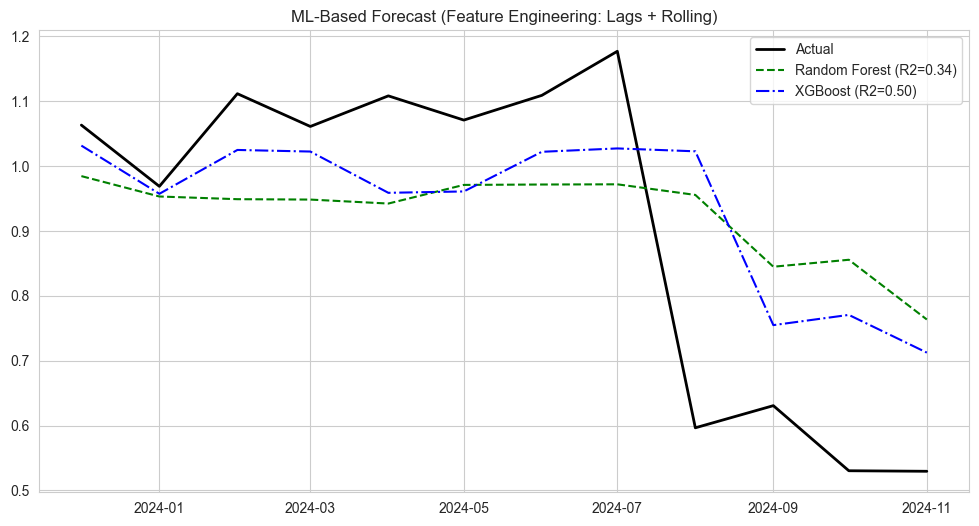

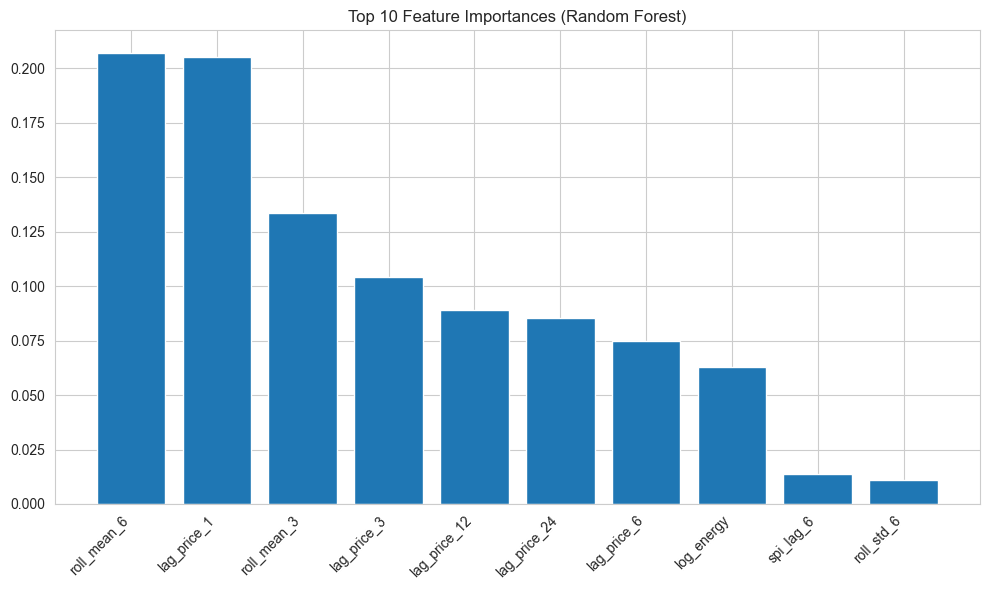

In [65]:
# 11. ML-Based Forecasting: XGBoost & Random Forest
# (Feature Engineering + Walk-Forward Split)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Try Importing XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    print("XGBoost not installed. Using RandomForest only.")
    XGB_AVAILABLE = False
# -------------------------------------------------------------
# 1. Feature Engineering
# -------------------------------------------------------------
# Base DataFrame
ml_df = model_df.copy().sort_index()
# Target
target_col = 'log_price'
# A. Lag Features (과거 가격 패턴)
# 1, 3, 6, 12개월 전 가격
lags = [1, 3, 6, 12, 24]
for lag in lags:
    ml_df[f'lag_price_{lag}'] = ml_df[target_col].shift(lag)
# B. Rolling Window Features (최근 추세)
# 최근 3개월, 6개월 평균/표준편차
ml_df['roll_mean_3'] = ml_df[target_col].shift(1).rolling(window=3).mean()
ml_df['roll_mean_6'] = ml_df[target_col].shift(1).rolling(window=6).mean()
ml_df['roll_std_6']  = ml_df[target_col].shift(1).rolling(window=6).std()
# C. Time Features (계절성)
ml_df['month_num'] = ml_df.index.month
ml_df['year_num'] = ml_df.index.year
# D. External Variables (이미 log 변환됨)
# 기존에 만들어둔 변수들 사용
ext_vars = ['log_energy', 'log_food', 'drought_severe', 'drought_spi', 'flood_severe', 'spi_lag_6']
# 존재하는 것만 선택
valid_ext = [c for c in ext_vars if c in ml_df.columns]
# E. Combine All Features
features = [f'lag_price_{l}' for l in lags] + \
           ['roll_mean_3', 'roll_mean_6', 'roll_std_6', 'month_num'] + \
           valid_ext
# 결측치 제거 (Lag 생성으로 인한 앞부분 NaN 제거)
ml_data = ml_df[[target_col] + features].dropna()
print(f"ML Dataset Shape: {ml_data.shape}")
# -------------------------------------------------------------
# 2. Train/Test Split (Time-based split)
# -------------------------------------------------------------
test_size = 12
train = ml_data.iloc[:-test_size]
test = ml_data.iloc[-test_size:]
X_train = train[features]
y_train = train[target_col]
X_test = test[features]
y_test = test[target_col]
test_dates = test.index
actual_prices = np.exp(y_test)
ml_results = []
ml_preds = pd.DataFrame(index=test_dates)
ml_preds['Actual'] = actual_prices
# -------------------------------------------------------------
# 3. Model Training & Prediction
# -------------------------------------------------------------
# (1) Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred_log = rf.predict(X_test)
rf_pred = np.exp(rf_pred_log)
ml_preds['RandomForest'] = rf_pred
rmse_rf = np.sqrt(mean_squared_error(actual_prices, rf_pred))
r2_rf = r2_score(actual_prices, rf_pred)
ml_results.append({'Model': 'Random Forest', 'RMSE': rmse_rf, 'R2': r2_rf})
# (2) XGBoost (if available)
if XGB_AVAILABLE:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                              n_estimators=200, 
                              learning_rate=0.05, 
                              max_depth=5, 
                              random_state=42)
    xg_reg.fit(X_train, y_train)
    
    xg_pred_log = xg_reg.predict(X_test)
    xg_pred = np.exp(xg_pred_log)
    
    ml_preds['XGBoost'] = xg_pred
    rmse_xg = np.sqrt(mean_squared_error(actual_prices, xg_pred))
    r2_xg = r2_score(actual_prices, xg_pred)
    ml_results.append({'Model': 'XGBoost', 'RMSE': rmse_xg, 'R2': r2_xg})
# -------------------------------------------------------------
# 4. Result Summary & Visualization
# -------------------------------------------------------------
print("\n--- ML Forecasting Results ---")
print(pd.DataFrame(ml_results))
# 4-1. Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(ml_preds.index, ml_preds['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(ml_preds.index, ml_preds['RandomForest'], label=f'Random Forest (R2={r2_rf:.2f})', linestyle='--', color='green')
if XGB_AVAILABLE:
    plt.plot(ml_preds.index, ml_preds['XGBoost'], label=f'XGBoost (R2={r2_xg:.2f})', linestyle='-.', color='blue')
plt.title("ML-Based Forecast (Feature Engineering: Lags + Rolling)")
plt.legend()
plt.show()
# 4-2. Feature Importance Check (RF 기준)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [features[i] for i in indices[:top_n]], rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [72]:
df.columns

Index(['countryiso3', 'commodity_group', 'commodity', 'price_per_kg', 'spi_1',
       'spi_3', 'spi_6', 'spi_12', 'spi_24', 'energy_index', 'food_index',
       'fertilizer_index', 'drought', 'flood', 'log_price', 'spi_lag_6',
       'drought_severe', 'flood_severe', 'drought_spi', 'flood_spi',
       'log_energy', 'log_fertilizer', 'log_food_index', 'log_drought_spi',
       'log_flood_spi', 'lag_price_1', 'lag_price_3', 'lag_price_12',
       'month_num', 'spi_12_lag_0', 'drought_severe_lag_0', 'spi_12_lag_1',
       'drought_severe_lag_1', 'spi_12_lag_2', 'drought_severe_lag_2',
       'spi_12_lag_3', 'drought_severe_lag_3', 'spi_12_lag_4',
       'drought_severe_lag_4', 'spi_12_lag_5', 'drought_severe_lag_5',
       'spi_12_lag_6', 'drought_severe_lag_6', 'spi_12_lag_7',
       'drought_severe_lag_7', 'spi_12_lag_8', 'drought_severe_lag_8',
       'spi_12_lag_9', 'drought_severe_lag_9', 'spi_12_lag_10',
       'drought_severe_lag_10', 'spi_12_lag_11', 'drought_severe_lag_11',
     

Testing Lags [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] for spi_12 & drought_severe...
Lag 0: 59 samples (Train: 47, Test: 12)
Lag 5: 57 samples (Train: 45, Test: 12)
Lag 10: 54 samples (Train: 42, Test: 12)
Lag 15: 50 samples (Train: 38, Test: 12)
Lag 20: 45 samples (Train: 33, Test: 12)

--- Best Lag Found: 23 months ---
R2: 0.6277, RMSE: 0.1506


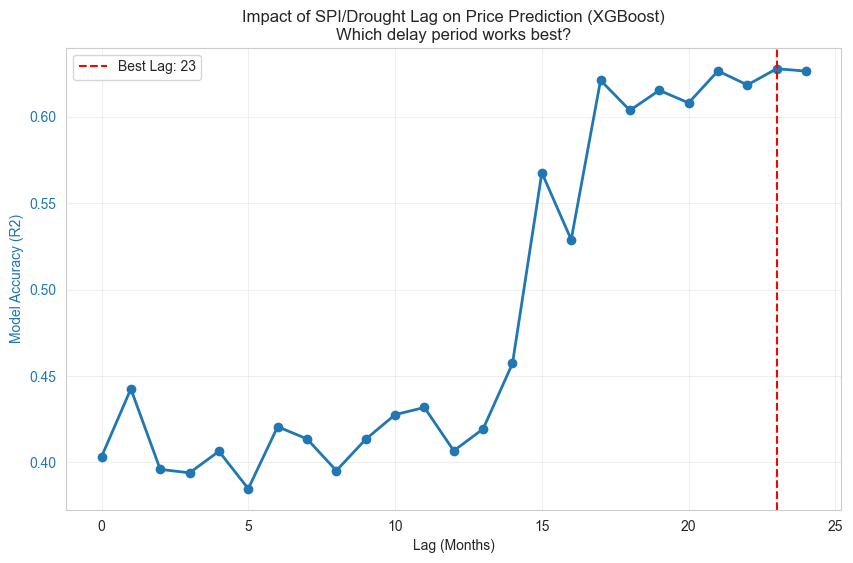

    Lag        R2      RMSE
23   23  0.627669  0.150635
21   21  0.626395  0.150893
24   24  0.626274  0.150917
17   17  0.620971  0.151984
22   22  0.618278  0.152523


In [73]:
# 12. Optimizing SPI/Drought Lags with XGBoost
# (Analyzing which time lag has the strongest impact on Price)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
# Test Lags: 0 to 24 months
test_lags = list(range(0, 25)) 
# Target Variable
target = 'log_price'
# Base Features (Fixed)
# 가격 자체의 과거 패턴(Autoregression)은 고정해두고, SPI Lag의 효과만 비교합니다.
# 이렇게 해야 "SPI Lag가 추가되었을 때의 순수 기여도"를 알 수 있습니다.
base_lags = [1, 3, 12] 
base_features = [f'lag_price_{l}' for l in base_lags] + ['month_num']
# SPI Variables to Test
# 어떤 변수의 Lag를 테스트할지 정합니다. (예: 12개월 SPI, 가뭄 지표)
spi_var = 'spi_12' 
drought_var = 'drought_severe'
print(f"Testing Lags {test_lags} for {spi_var} & {drought_var}...")
lag_results = []
# Data Prep (Basic)
df = model_df.copy().sort_index()
# Create Base Features
for l in base_lags:
    df[f'lag_price_{l}'] = df[target].shift(l)
df['month_num'] = df.index.month
# -------------------------------------------------------------
# Loop through Lags
# -------------------------------------------------------------
for k in test_lags:
    # 1. Create Lagged Features for this iteration
    col_spi_lag = f'{spi_var}_lag_{k}'
    col_drought_lag = f'{drought_var}_lag_{k}'
    
    df[col_spi_lag] = df[spi_var].shift(k)
    df[col_drought_lag] = df[drought_var].shift(k)
    
    # Combined Features for Model
    current_features = base_features + [col_spi_lag, col_drought_lag]
    
    # 2. Clean Data (Lagging creates NaNs at the beginning)
    temp_df = df[[target] + current_features].dropna()
    n_samples = len(temp_df)
    
    # Safety Check: Data Sufficiency
    # We need at least enough for Test (12) + Training (e.g. 24) = 36
    if n_samples < 36: 
        print(f"Skipping Lag {k}: Too few samples ({n_samples}) to split reliably.")
        continue
    
    # 3. Train/Test Split (Time-based, Last 12 months Test)
    train_size = n_samples - 12
    X_train = temp_df.iloc[:train_size][current_features]
    y_train = temp_df.iloc[:train_size][target]
    X_test = temp_df.iloc[train_size:][current_features]
    y_test = temp_df.iloc[train_size:][target]
    
    # Debug info for user concern
    if k % 5 == 0 or k == 15: # Print for every 5th lag or specific user concern
        print(f"Lag {k}: {n_samples} samples (Train: {train_size}, Test: 12)")
    
    actual = np.exp(y_test)
    
    # 4. Train XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             max_depth=4, 
                             learning_rate=0.05, 
                             random_state=42)
    model.fit(X_train, y_train)
    
    # 5. Evaluate
    pred_log = model.predict(X_test)
    pred = np.exp(pred_log)
    
    r2 = r2_score(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    
    lag_results.append({
        'Lag': k,
        'R2': r2,
        'RMSE': rmse
    })
# -------------------------------------------------------------
# Visualization
# -------------------------------------------------------------
res_df = pd.DataFrame(lag_results)
# Best Lag Found
best_lag_row = res_df.loc[res_df['R2'].idxmax()]
print(f"\n--- Best Lag Found: {int(best_lag_row['Lag'])} months ---")
print(f"R2: {best_lag_row['R2']:.4f}, RMSE: {best_lag_row['RMSE']:.4f}")
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:blue'
ax1.set_xlabel('Lag (Months)')
ax1.set_ylabel('Model Accuracy (R2)', color=color)
ax1.plot(res_df['Lag'], res_df['R2'], marker='o', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)
# Highlight Best Lag
ax1.axvline(best_lag_row['Lag'], color='red', linestyle='--', label=f'Best Lag: {int(best_lag_row["Lag"])}')
ax1.legend()
plt.title(f"Impact of SPI/Drought Lag on Price Prediction (XGBoost)\nWhich delay period works best?")
plt.show()
print(res_df.sort_values('R2', ascending=False).head())

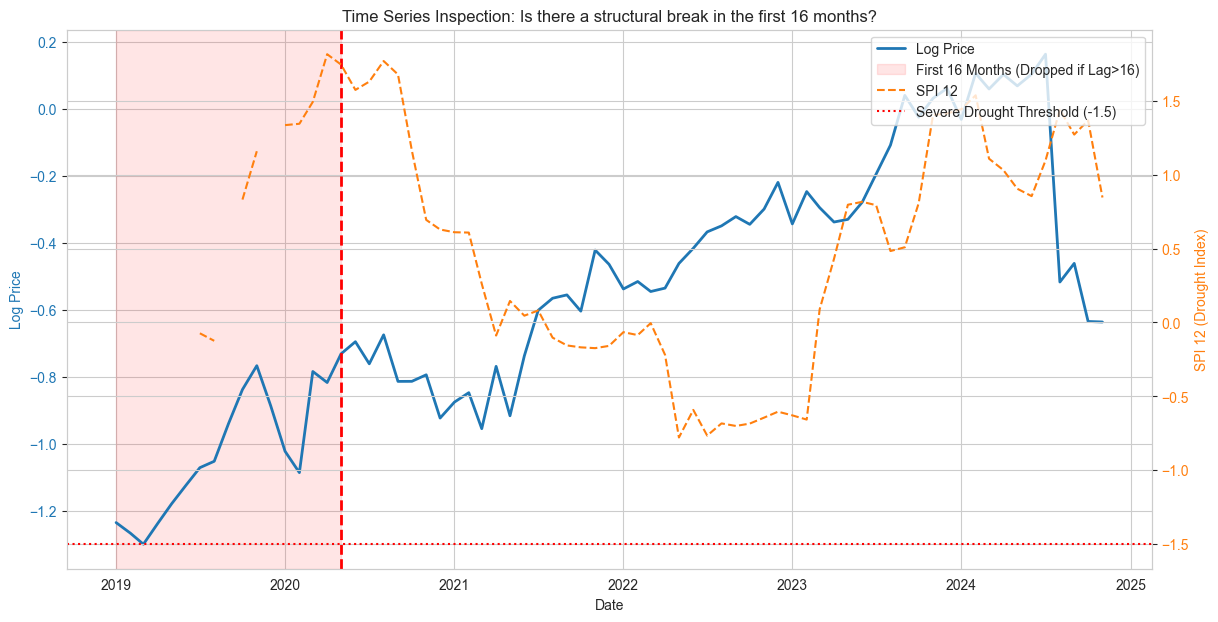


--- Statistical Comparison ---
Early Period (First 16 months):
       log_price     spi_12
count  16.000000  10.000000
mean   -1.036946   0.854021
std     0.180632   0.681269
min    -1.298650  -0.124015
25%    -1.192007   0.334313
50%    -1.060784   0.994951
75%    -0.873524   1.341992
max    -0.766148   1.814740

Rest of Period:
       log_price     spi_12
count  55.000000  55.000000
mean   -0.420354   0.456692
std     0.314952   0.787177
min    -0.953993  -0.777899
25%    -0.654942  -0.156741
50%    -0.460978   0.508887
75%    -0.233093   1.101818
max     0.162872   1.768725

Difference in Mean Log Price: -0.6166
ALERT: Significant difference in price levels found!


In [74]:
# 13. Data Anomaly Investigation (Time Series Inspection)
# (Visualizing data to check for structural breaks in the early period)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
# Period of interest (User suspects anomaly in first 16 months)
anomaly_cutoff = 16 
# Variables to Inspect
price_col = 'log_price'
spi_col = 'spi_12'
drought_col = 'drought_severe'
# Data Prep
df = model_df.copy().sort_index()
# -------------------------------------------------------------
# Visualization
# -------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(14, 7))
# 1. Plot Price (Log Scale)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Price', color=color)
ax1.plot(df.index, df[price_col], color=color, linewidth=2, label='Log Price')
ax1.tick_params(axis='y', labelcolor=color)
# 2. Highlight Early Period (First 16 Months)
cutoff_date = df.index[anomaly_cutoff]
ax1.axvspan(df.index[0], cutoff_date, color='red', alpha=0.1, label=f'First {anomaly_cutoff} Months (Dropped if Lag>{anomaly_cutoff})')
ax1.axvline(cutoff_date, color='red', linestyle='--', linewidth=2)
# 3. Plot SPI on Secondary Axis
ax2 = ax1.twinx() 
color = 'tab:orange'
ax2.set_ylabel('SPI 12 (Drought Index)', color=color)
ax2.plot(df.index, df[spi_col], color=color, linestyle='--', label='SPI 12')
# Highlight Drought Threshold
ax2.axhline(-1.5, color='red', linestyle=':', label='Severe Drought Threshold (-1.5)')
ax2.tick_params(axis='y', labelcolor=color)
# Title & Legend
plt.title(f"Time Series Inspection: Is there a structural break in the first {anomaly_cutoff} months?")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()
# -------------------------------------------------------------
# Statistical Check (Early vs Rest)
# -------------------------------------------------------------
early_period = df.iloc[:anomaly_cutoff]
rest_period = df.iloc[anomaly_cutoff:]
print(f"\n--- Statistical Comparison ---")
print(f"Early Period (First {anomaly_cutoff} months):")
print(early_period[[price_col, spi_col]].describe())
print(f"\nRest of Period:")
print(rest_period[[price_col, spi_col]].describe())
mean_diff_price = early_period[price_col].mean() - rest_period[price_col].mean()
print(f"\nDifference in Mean Log Price: {mean_diff_price:.4f}")
if abs(mean_diff_price) > 0.5:
    print("ALERT: Significant difference in price levels found!")
else:
    print("Price levels seem relatively stable (no massive structural break in mean).")